# ML pipeline for a single assay endpoint

### Imports

In [27]:
import os
import yaml
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


### Load assay endpoint and QSAR-ready chemical structure fingerprints
Note: Many chemicals from assays do not have a fingerprint -> small training data

In [28]:
# Define the root directory
ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
CONFIG_PATH = os.path.join(ROOT_DIR, 'config', 'config_ml.yaml')


def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        if config["ignore_warnings"]:
            import warnings
            warnings.filterwarnings("ignore")

    return config  

 
config = load_config(CONFIG_PATH)

# Define the file paths
assay_file_path = os.path.join(ROOT_DIR, "export", "out", f"{config['aeid']}.csv")
fps_file_path = os.path.join(ROOT_DIR, 'input', 'ToxCast_CSIfps.csv')  # df_sirius_fps, ToxCast_CSIfps

# Read the CSV files
assay_df = pd.read_csv(assay_file_path)
fps_df = pd.read_csv(fps_file_path).iloc[:, 3:].T

data = fps_df.iloc[1:].values.astype(int)
index = fps_df.index[1:]
columns = fps_df.iloc[0]

fps_df = pd.DataFrame(data=data, index=index, columns=columns).reset_index(drop=True)
fps_df = fps_df.rename(columns={"index": "dtxsid"})

# Drop the duplicates in the fingerprint dataframe
fps_df = fps_df.drop_duplicates(subset="dtxsid")  
# which fingerprints should be dropped with the same dtxsid? identical or not? double check

# Get the intersection of the two dataframes
df = pd.merge(assay_df, fps_df, on="dtxsid").reset_index(drop=True)

print(f"ML pipeline for assay ID: {config['aeid']}\n")
print(f"Fingerprint dataframe shape: {fps_df.shape}")
print(f"Assay dataframe, total: {assay_df.shape[0]} chemical/hitcall datapoints")
print(f"{assay_df['hitc'].value_counts()}\n")
print(f"Number of datapoints for this ML pipeline: {df['dtxsid'].nunique()}\n")


KeyError: Index(['dtxsid'], dtype='object')

### Split data into train and test sets

In [ ]:
config = load_config(CONFIG_PATH)

# Split the data into features (X) and labels (y)
X = df.iloc[:, 2:]  # Select all columns, starting from the third column (fingerprint features)
y = df['hitc']  

# Split the data into train and test sets before oversampling to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=config['train_test_split_ratio'],
                                                    random_state=config['random_state'],
                                                    shuffle=True, # shuffle the data before splitting (default)
                                                    stratify=y) # stratify to ensure the same class distribution in the train and test sets

print(f"Label Counts TOTAL: {len(y)} datapoints")
print(f"{y.value_counts()}\n")
print(f"Label Counts TRAIN: {len(y_train)} datapoints")
print(f"{y_train.value_counts()}\n")
print(f"Label Counts TEST: {len(y_test)} datapoints")
print(f"{y_test.value_counts()}\n")

# Perform SMOTE oversampling? within the nested cross-validation loop with hyper-parameter tuning?
if config['apply']['smote']:
    oversampler = SMOTE(random_state=config['random_state'])
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


print(f"Label Counts TRAIN (after oversampling): {len(y_train)} datapoints")
print(f"{y_train.value_counts()}\n")

Label Counts TOTAL: 7611 datapoints
hitc
False    7239
True      372
Name: count, dtype: int64

Label Counts TRAIN: 6088 datapoints
hitc
False    5790
True      298
Name: count, dtype: int64

Label Counts TEST: 1523 datapoints
hitc
False    1449
True       74
Name: count, dtype: int64

Label Counts TRAIN (after oversampling): 11580 datapoints
hitc
False    5790
True     5790
Name: count, dtype: int64



### Build classifier pipeline

In [ ]:
config = load_config(CONFIG_PATH)

# build for each classifier a pipeline with the steps defined in the config file
def build_pipeline(steps):
    pipeline_steps = []
    for step in steps:
        step_name = step['name']  
        step_args = step.get('args', {}) # get the hyperparameters for the step, if any
        step_instance = globals()[step_name](**step_args)  # dynmically create an instance of the step
        pipeline_steps.append((step_name, step_instance))  
    return Pipeline(pipeline_steps)


def build_param_grid(classifier_steps):
    param_grid = {}
    for step in classifier_steps:
        step_name = step['name']
        step_args = step.get('args', {})
        param_grid.update({f'{step_name}__{key}': value for key, value in step_args.items() if isinstance(value, list)})
    return param_grid


def grid_search_cv(classifier, pipeline):
    grid_search = GridSearchCV(pipeline, 
                               param_grid=build_param_grid(classifier['steps']),
                               cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=config['random_state']), # outer grid: 5-fold cross-validation repeated 3 times
                               scoring=config["grid_search_cv"]["scoring"], # macro f1 score, beta?
                               n_jobs=config["grid_search_cv"]["n_jobs"],
                               verbose=config["grid_search_cv"]["verbose"],
                               ).fit(X_train, y_train)
    
    print(f"{classifier['name']}: GridSearchCV Results:")
    best_params = grid_search.best_params_ if grid_search.best_params_ else "default"
    print(f"Best params:\n{best_params} with mean cross-validated score: {grid_search.best_score_}\n")

    return grid_search
    

def predict_and_report(classifier, best_estimator):
    print(f"Predict..")
    y_pred = best_estimator.predict(X_test)

    labels = [True, False] 
    print(f"Classification Report {classifier['name']}:")
    print(classification_report(y_test, y_pred, labels=labels))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()   # Extract values from confusion matrix
    print(f"Total: {len(y_test)} datapoints")
    print(f"Ground truth: {tn + fp} positive, {tp + fn} negative")
    print(f"Prediction: {tn + fn} positive, {tp + fp} negative")

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Positive", "Negative"])
    cm_display.plot()
    plt.title(f"Confusion Matrix for {classifier['name']}")
    plt.show()
    

### Pipeline: Grid Search CV + Prediction + Classification report

Fitting 15 folds for each of 1 candidates, totalling 15 fits
XGBClassifier: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.974496257915947

Predict..
Classification Report XGBClassifier:
              precision    recall  f1-score   support

        True       0.45      0.47      0.46        74
       False       0.97      0.97      0.97      1449

    accuracy                           0.95      1523
   macro avg       0.71      0.72      0.72      1523
weighted avg       0.95      0.95      0.95      1523

Total: 1523 datapoints
Ground truth: 74 positive, 1449 negative
Prediction: 78 positive, 1445 negative


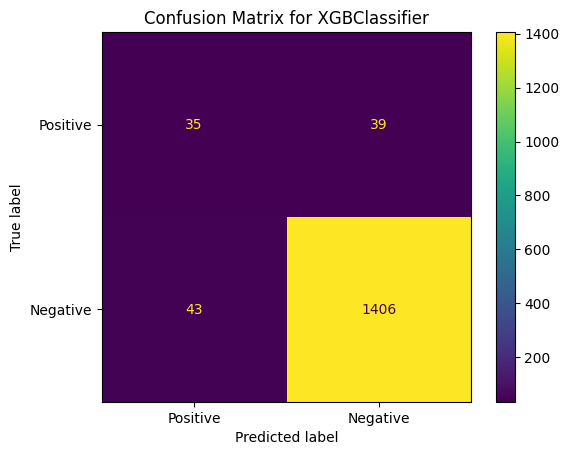

Done: XGBClassifier >> 190.33 seconds.
___________________________________________________________________________


Done. Total time >> 190.33 seconds.



In [29]:
config = load_config(CONFIG_PATH)

total_time_start = time.time()

for classifier in config['classifiers']:
    start_time = time.time()
    
    # Build the pipeline for the current classifier
    pipeline = build_pipeline(classifier['steps'])

    # Perform grid search on the extracted hyperparameters
    grid_search = grid_search_cv(classifier, pipeline)

    # Predict on the test set and best estimator
    predict_and_report(classifier, grid_search.best_estimator_)

    print(f"Done: {classifier['name']} >> {round(time.time() - start_time, 2)} seconds.\n{'_' * 75}\n\n")

print(f"Done. Total time >> {round(time.time() - total_time_start, 2)} seconds.\n")
    